In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/RaghavAgrawal17/Brain-tumor-datasets/archive/refs/heads/master.zip" \
    -O "/tmp/dataset.zip"


zip_ref = zipfile.ZipFile('/tmp/dataset.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-08-26 03:46:46--  https://github.com/RaghavAgrawal17/Brain-tumor-datasets/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/RaghavAgrawal17/Brain-tumor-datasets/zip/refs/heads/master [following]
--2022-08-26 03:46:46--  https://codeload.github.com/RaghavAgrawal17/Brain-tumor-datasets/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip        [       <=>          ]  34.32M  25.5MB/s    in 1.3s    

2022-08-26 03:46:48 (25.5 MB/s) - ‘/tmp/dataset.zip’ saved [35988054]



In [ ]:
from sklearn.decomposition import PCA
import tensorflow as tf
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.utils import shuffle
from skimage import filters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import accuracy_score
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [ ]:
def show_before_and_after(before,after):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(before,plt.cm.gray)
    plt.title('Before')
    plt.subplot(1,2,2)
    plt.imshow(after,plt.cm.gray)
    plt.title('After')
    plt.show()

In [ ]:
def convert_to_grayscale(image):
    gray_scale_img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return gray_scale_img

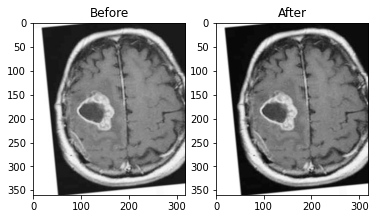

In [ ]:
#Converting to gray scale
sample_img=cv2.imread("/tmp/Brain-tumor-datasets-master/Desktop/synthesized_data/yes/aug_Y10_0_1546.jpg")
gray_scale_img_of_sample=convert_to_grayscale(sample_img)
show_before_and_after(sample_img,gray_scale_img_of_sample)

In [ ]:
#Reduces image size and down sampling the image
def gaussian_blur(image):
    return cv2.GaussianBlur(image,(5,5),0)

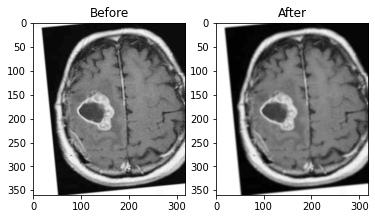

In [ ]:
#Blurring the image
slightly_blurred_image=gaussian_blur(gray_scale_img_of_sample)
show_before_and_after(gray_scale_img_of_sample,slightly_blurred_image)

In [ ]:
def threshold_image(image):
    ret,th=cv2.threshold(image,45,255,cv2.THRESH_BINARY)
    return th

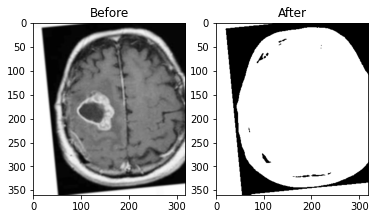

In [ ]:
#Thresholding image
#A method of image segmentation which segments foreground from background
thresh_image=threshold_image(slightly_blurred_image)
#show_before_and_after(slightly_blurred_image,thresh_image)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(slightly_blurred_image,plt.cm.gray)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(thresh_image,plt.cm.gray)
plt.title('After')
plt.show()

In [ ]:
def erode_image(image):
     return cv2.erode(image, None, iterations=2)

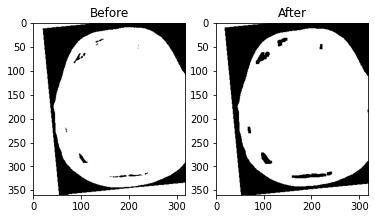

In [ ]:
#Eroding image
#The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object
eroded_img=erode_image(thresh_image)

show_before_and_after(thresh_image,eroded_img)

In [ ]:
def dilate_img(image):
    return cv2.dilate(image, None, iterations=2)

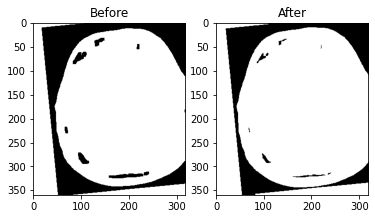

In [ ]:
#Dilating image
#Dilation adds pixels to object boundaries
dilated_img=dilate_img(eroded_img)
show_before_and_after(eroded_img,dilated_img)

In [ ]:
def crop_image_coordinates(image,plot=False):
    #Grabbing largest contours
    cntrs=cv2.findContours(image.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cntrs = imutils.grab_contours(cntrs)
    largest_cntr = max(cntrs, key=cv2.contourArea)
    #Extreme points finding for cropping
    ext_left = tuple(largest_cntr[largest_cntr[:, :, 0].argmin()][0])
    ext_right = tuple(largest_cntr[largest_cntr[:, :, 0].argmax()][0])
    ext_top = tuple(largest_cntr[largest_cntr[:, :, 1].argmin()][0])
    ext_bot = tuple(largest_cntr[largest_cntr[:, :, 1].argmax()][0])
    return [ext_left,ext_right,ext_top,ext_bot]

In [ ]:
def crop_image(image,crop_image_coords):
    return image[crop_image_coords[2][1]:crop_image_coords[3][1], crop_image_coords[0][0]:crop_image_coords[1][0]]

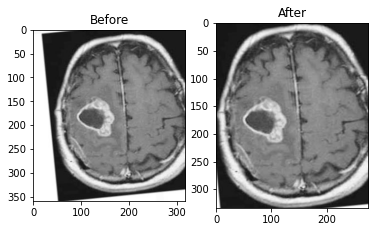

In [ ]:
#Cropping only the brain image
coords=crop_image_coordinates(dilated_img)
cropped_image=crop_image(sample_img,coords)
show_before_and_after(sample_img,cropped_image)

In [ ]:
def resize_image(image,size):
    width,height=size
    return cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)

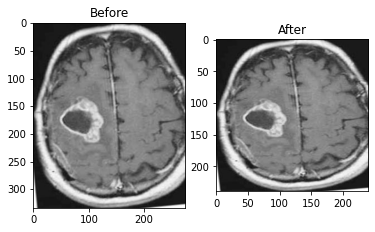

In [ ]:
#Resizing image
resized_image=resize_image(cropped_image,[240,240])
show_before_and_after(cropped_image,resized_image)

In [ ]:
def normalize_image(image):
    return image/255

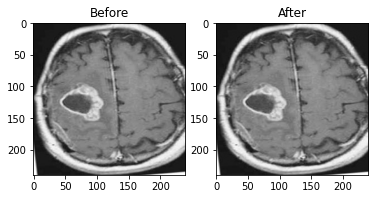

In [ ]:
#Normalizing image
normalized_image=normalize_image(resized_image)
show_before_and_after(resized_image,normalized_image)

In [ ]:
def prepare_image(image):
    return normalize_image(resize_image(crop_image(image,crop_image_coordinates(dilate_img(erode_image(threshold_image(gaussian_blur(convert_to_grayscale(image))))))),[240,240]))

In [ ]:
# Performing above steps on the whole dataset
def load_data(directory_list, image_size):

    # load all images in a directory
    Image = []
    label = []
    width, height = image_size

    for directory in directory_list:
        for filename in os.listdir(directory):
            #load the image

            image = cv2.imread(directory + '/' + filename)
            image = prepare_image(image)
            Image.append(image)
            # append a value of 1 to the label array if the image
            # is in the folder named 'yes', else append 0.
            if directory[-3:] == 'yes':
                label.append([1])
            else:
                label.append([0])

    Image = np.array(Image)
    label = np.array(label)

    # Shuffle the data
    Image, label = shuffle(Image, label)

    return Image, label

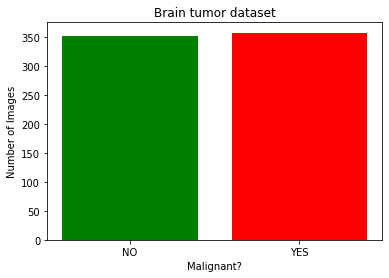

In [ ]:
#Visualization1 - Number of benign and malignant tumor scans

data_path="/tmp/Brain-tumor-datasets-master/Desktop/synthesized_data/"
data_path_yes=data_path+'yes'
data_path_no=data_path+'no'
width,height=(240,240)
Image,label=load_data([data_path_yes,data_path_no],[width,height])
label_list=label.tolist()
no_yes_count=[0,0]
for i in range(len(label_list)):
    no_yes_count[label_list[i][0]]+=1
xaxis=["NO","YES"]
yaxis=no_yes_count
plt.figure()
plt.bar(xaxis,yaxis,color=['green','red'])
plt.xlabel("Malignant?")
plt.ylabel("Number of Images")
plt.title("Brain tumor dataset")
plt.show()

In [ ]:
no_yes_count

[352, 358]

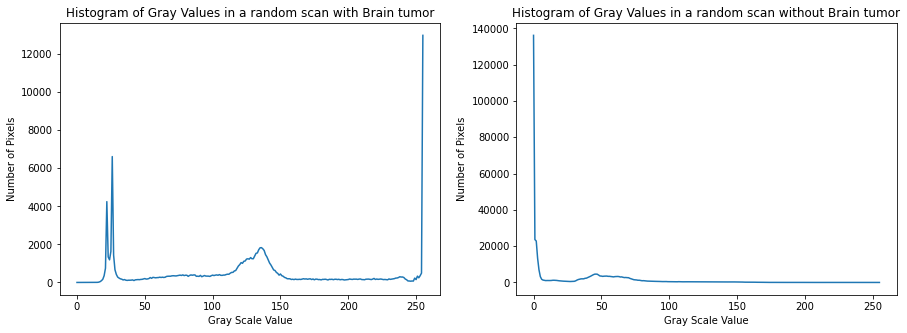

In [ ]:
#Visualization2- Histogram of gray scale intensity
yes_img=cv2.imread("/tmp/Brain-tumor-datasets-master/Desktop/synthesized_data/yes/aug_Y10_0_1546.jpg")
no_img=cv2.imread("/tmp/Brain-tumor-datasets-master/Desktop/synthesized_data/no/aug_1 no._0_1102.jpg")
yes_img=convert_to_grayscale(yes_img)
no_img=convert_to_grayscale(no_img)
histg_yes = cv2.calcHist([yes_img],[0],None,[256],[0,256])
histg_no = cv2.calcHist([no_img],[0],None,[256],[0,256])
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(histg_yes)
plt.xlabel("Gray Scale Value")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Gray Values in a random scan with Brain tumor")
plt.subplot(1,2,2)
plt.xlabel("Gray Scale Value")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Gray Values in a random scan without Brain tumor")

plt.plot(histg_no)

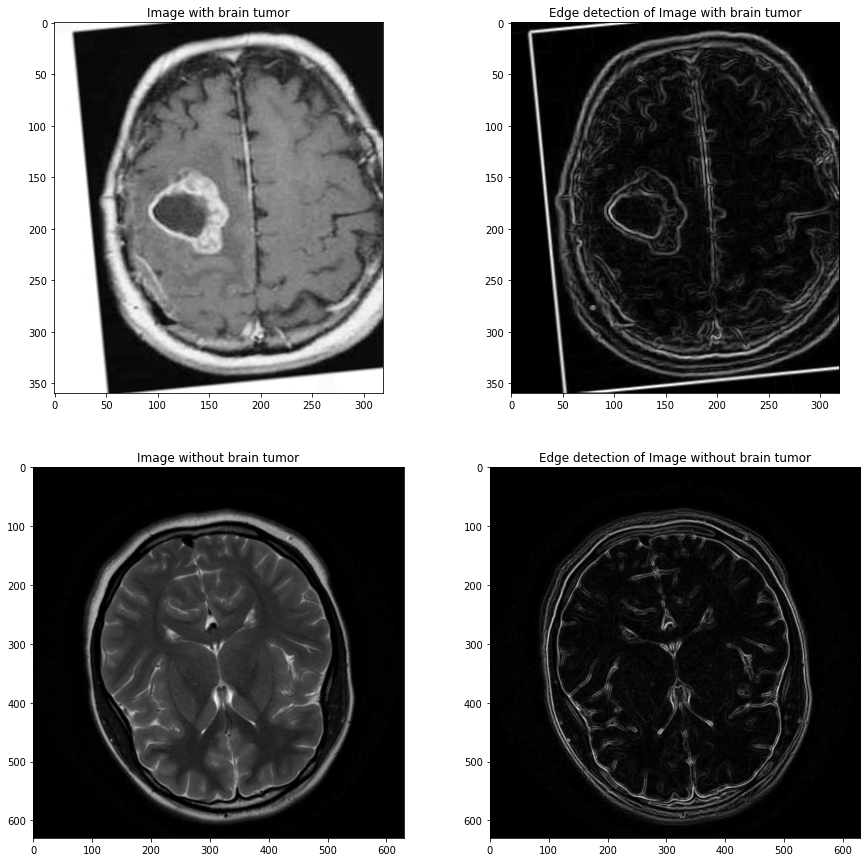

In [ ]:
#Visualization3 -Detecting Edges

edges_of_image_yes = filters.sobel(yes_img)
edges_of_image_no = filters.sobel(no_img)

plt.figure(figsize=[15,15])
plt.subplot(2,2,1)
plt.imshow(yes_img,plt.cm.gray)
plt.title("Image with brain tumor")
plt.subplot(2,2,2)
plt.title("Edge detection of Image with brain tumor")
plt.imshow(edges_of_image_yes,plt.cm.gray)


plt.subplot(2,2,3)
plt.imshow(no_img,plt.cm.gray)
plt.title("Image without brain tumor")
plt.subplot(2,2,4)
plt.title("Edge detection of Image without brain tumor")
plt.imshow(edges_of_image_no,plt.cm.gray)

plt.show()

In [ ]:
Image.shape

(710, 240, 240, 3)

In [ ]:
len(label)

710

In [ ]:
Image=Image[0:len(label)]
Image=Image[0:len(label)]

In [ ]:
l=[]
for image_no in range((Image.shape)[0]):
  l.append(Image[image_no].ravel())
df=pd.DataFrame(l,columns=[i for i in range(len(l[0]))])
df["Target"]=label
df.head()

,0,1,2,3,4,5,6,7,8,9,...,172791,172792,172793,172794,172795,172796,172797,172798,172799,Target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
X=df[df.columns[0:-1]]
y=df['Target']

In [ ]:
#Train and test split
X_train,X_test,Y_train,Y_test=train_test_split(X, y, test_size = 0.2, random_state = 0)
X_Train = X_train
#X_train = X
#Y_train = y
X_Train

,0,1,2,3,4,5,6,7,8,9,...,172790,172791,172792,172793,172794,172795,172796,172797,172798,172799
483,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843
690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027451,0.023529,0.023529,0.023529,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765
17,0.050980,0.050980,0.050980,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.062745,...,0.062745,0.058824,0.058824,0.058824,0.078431,0.078431,0.078431,0.086275,0.086275,0.086275
477,0.156863,0.156863,0.156863,0.188235,0.188235,0.188235,0.196078,0.196078,0.196078,0.176471,...,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549,0.172549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843
192,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,...,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765
629,0.098039,0.098039,0.098039,0.094118,0.094118,0.094118,0.090196,0.090196,0.090196,0.086275,...,0.443137,0.443137,0.443137,0.443137,0.443137,0.443137,0.443137,0.439216,0.439216,0.439216
559,0.035294,0.035294,0.035294,0.047059,0.047059,0.047059,0.066667,0.066667,0.066667,0.070588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pca = PCA(n_components = X_train.shape[0])
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


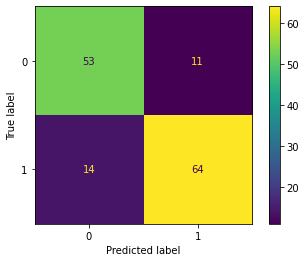

In [ ]:
#Limited memory Broyden–Fletcher–Goldfarb–Shanno
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(32,16,8,4,2), random_state=0)
clf.fit(X_train, Y_train)
y_pred=clf.predict(X_test)
mlp_acc=accuracy_score(Y_test,y_pred)
plot_confusion_matrix(clf, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


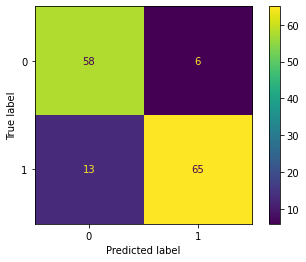

In [ ]:
model_svm=svm.SVC()
model_svm.fit(X_train,Y_train)
y_pred=model_svm.predict(X_test)
svm_acc=accuracy_score(Y_test,y_pred)
plot_confusion_matrix(model_svm, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


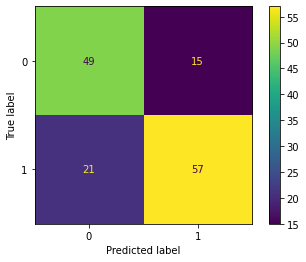

In [ ]:
dtree=DecisionTreeClassifier(max_depth=10,random_state=0)
model=dtree.fit(X_train,Y_train)
y_pred=model.predict(X_test)
dtree_acc=accuracy_score(Y_test,y_pred)
plot_confusion_matrix(dtree, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


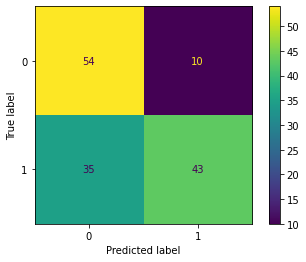

In [ ]:
rtree=RandomForestClassifier(n_estimators=128,random_state=0)
model=rtree.fit(X_train,Y_train)
y_pred=model.predict(X_test)
rtree_acc=accuracy_score(Y_test,y_pred)
plot_confusion_matrix(rtree, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


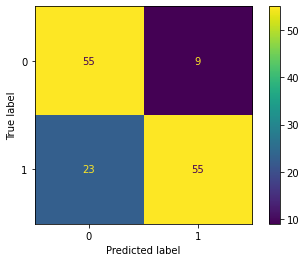

In [ ]:
lr=LogisticRegression(max_iter=250)
model=lr.fit(X_train,Y_train)
y_pred=model.predict(X_test)
lr_acc=accuracy_score(Y_test,y_pred)
plot_confusion_matrix(lr, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


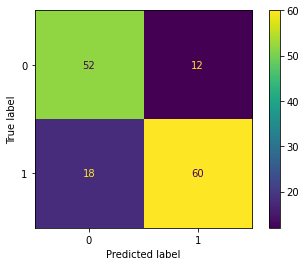

In [ ]:
xc=XGBClassifier()
model=xc.fit(X_train,Y_train)
y_pred=model.predict(X_test)
xc_acc=accuracy_score(Y_test,y_pred)
plot_confusion_matrix(model, X_test, Y_test)

In [ ]:
X_train.shape

(568, 568)

In [ ]:
def metrics_parameters1(history):

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
X_train_,X_test_,Y_train_,Y_test_= train_test_split(Image, label, test_size = 0.2, random_state = 0)

In [ ]:
base_model = VGG16(input_shape = (240, 240, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
vgghist = model.fit(x=X_train_, y=Y_train_, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
15/15 [==============================] - 4s 247ms/step - loss: 1.3272 - acc: 0.5396 - val_loss: 1.3675 - val_acc: 0.4912
Epoch 2/20
15/15 [==============================] - 3s 227ms/step - loss: 0.4700 - acc: 0.7819 - val_loss: 1.0857 - val_acc: 0.5000
Epoch 3/20
15/15 [==============================] - 3s 228ms/step - loss: 0.5278 - acc: 0.7269 - val_loss: 0.3304 - val_acc: 0.8333
Epoch 4/20
15/15 [==============================] - 3s 232ms/step - loss: 0.2677 - acc: 0.8965 - val_loss: 0.4028 - val_acc: 0.7368
Epoch 5/20
15/15 [==============================] - 3s 234ms/step - loss: 0.3098 - acc: 0.8480 - val_loss: 0.3692 - val_acc: 0.8070
Epoch 6/20
15/15 [==============================] - 3s 236ms/step - loss: 0.1810 - acc: 0.9361 - val_loss: 0.5112 - val_acc: 0.7281
Epoch 7/20
15/15 [==============================] - 4s 237ms/step - loss: 0.2286 - acc: 0.9097 - val_loss: 0.5203 - val_acc: 0.7368
Epoch 8/20
15/15 [==============================] - 4s 242ms/step - loss: 0.

loss
acc
val_loss
val_acc


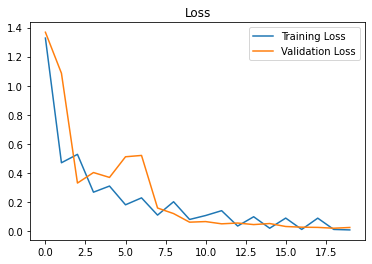

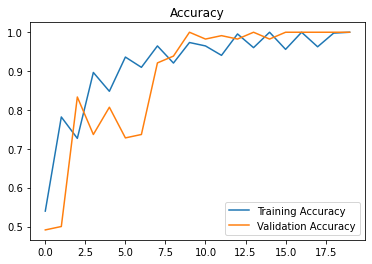

In [ ]:
for key in vgghist.history.keys():
    print(key)
metrics_parameters1(vgghist)

In [ ]:
loss, vgg_acc = model.evaluate(x=X_test_, y=Y_test_)

5/5 [==============================] - 1s 159ms/step - loss: 0.0721 - acc: 0.9718


In [ ]:
def metrics_parameters(history):

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

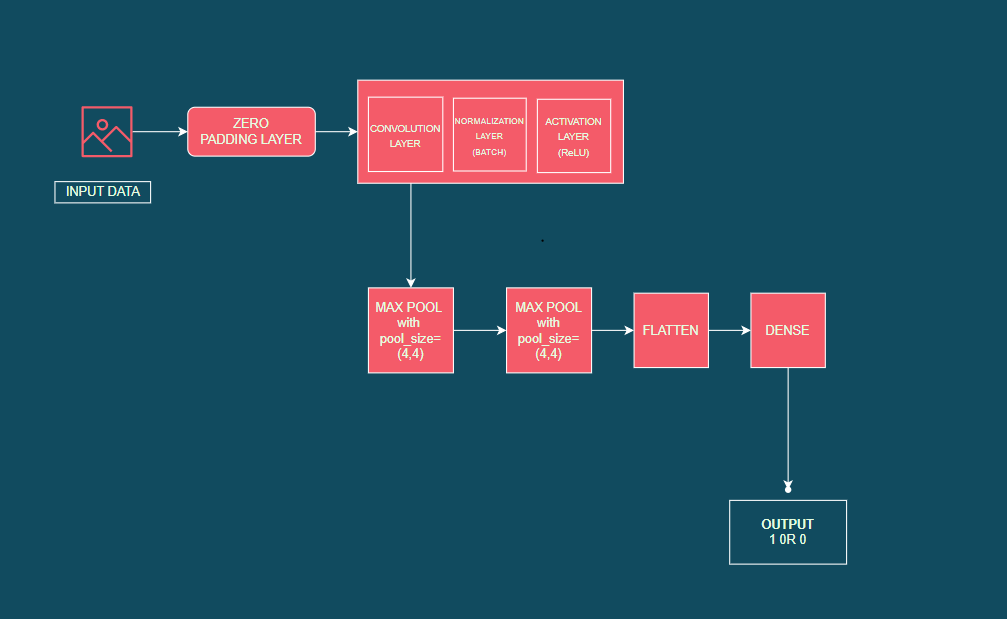

In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape)

    #Padding zeroes to the input
    X = ZeroPadding2D((2, 2))(X_input)

    #Convolution
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    #Batch Normalization
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    #ACtivation Function-Relu(Rectified Linear Unit)
    X = Activation('relu')(X)
    #Pooling with max value
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    #Pooling with max value
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    #Converting the higher dimensional data to 1D data
    X = Flatten()(X)
    #Creating a dense fully connected neural network
    X = Dense(1, activation='sigmoid', name='fc')(X)
    #Creating instance of keras model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [ ]:
X_train_,X_test_,Y_train_,Y_test_= train_test_split(Image, label, test_size = 0.2, random_state = 0)
X_train_ = Image
Y_train_ = label
model_cnn=build_model((240,240,3))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_cnn.fit(x=X_train_, y=Y_train_, batch_size=32, epochs=60, validation_split=0.2)

Epoch 1/60
18/18 [==============================] - 3s 102ms/step - loss: 1.1894 - accuracy: 0.5599 - val_loss: 0.6710 - val_accuracy: 0.5915
Epoch 2/60
18/18 [==============================] - 1s 65ms/step - loss: 0.5577 - accuracy: 0.7218 - val_loss: 0.6466 - val_accuracy: 0.6690
Epoch 3/60
18/18 [==============================] - 1s 64ms/step - loss: 0.4074 - accuracy: 0.8275 - val_loss: 0.6311 - val_accuracy: 0.6972
Epoch 4/60
18/18 [==============================] - 1s 65ms/step - loss: 0.3372 - accuracy: 0.8680 - val_loss: 0.6143 - val_accuracy: 0.7465
Epoch 5/60
18/18 [==============================] - 1s 66ms/step - loss: 0.2677 - accuracy: 0.9102 - val_loss: 0.6229 - val_accuracy: 0.6056
Epoch 6/60
18/18 [==============================] - 1s 65ms/step - loss: 0.2333 - accuracy: 0.9384 - val_loss: 0.6006 - val_accuracy: 0.6338
Epoch 7/60
18/18 [==============================] - 1s 65ms/step - loss: 0.2139 - accuracy: 0.9366 - val_loss: 0.5726 - val_accuracy: 0.7465
Epoch 8/60
1

loss
accuracy
val_loss
val_accuracy


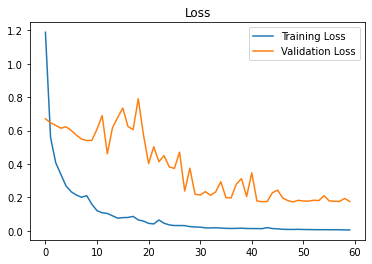

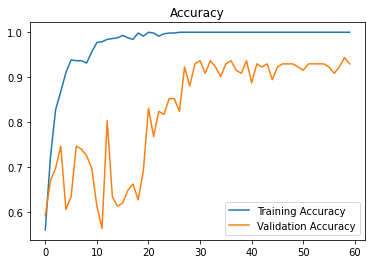

In [ ]:
for key in history.history.keys():
    print(key)
metrics_parameters(history)

In [ ]:
model_1 = XGBClassifier()
model_2 = LogisticRegression(max_iter=200)
model_3 = svm.SVC(kernel="poly",probability=True)
model_4 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(64,32,16,8,4,2), random_state=0)
model_5 = svm.SVC(kernel="rbf",probability=True)

final_model = VotingClassifier(estimators=[('XGB', model_1),('LR', model_2),('svm1', model_3),('MLP',model_4),('svm2',model_5)], voting='hard')
final_model.fit(X_train,Y_train)
y_pred=final_model.predict(X_test)
confusion_matrix(Y_test,y_pred)
cnn_acc=accuracy_score(Y_test,y_pred)
y_pred=final_model.predict(X_test)
ensem_acc=accuracy_score(Y_test,y_pred)

In [ ]:
loss, cnn_acc = model_cnn.evaluate(x=X_test_, y=Y_test_)

5/5 [==============================] - 0s 28ms/step - loss: 0.0352 - accuracy: 0.9859


In [ ]:
print("Multilayer Perceptron Accuracy:", mlp_acc)
print("SVM Accuracy:",svm_acc)
print("Decision Tree Accuracy:",dtree_acc)
print("Random Forest Accuracy:",rtree_acc)
print("Logistic Regression Accuracy:",lr_acc)
print("Ensemble Accuracy:",ensem_acc)
print("XGBoost Accuracy:",xc_acc)

Multilayer Perceptron Accuracy: 0.823943661971831
SVM Accuracy: 0.8661971830985915
Decision Tree Accuracy: 0.7464788732394366
Random Forest Accuracy: 0.6830985915492958
Logistic Regression Accuracy: 0.7746478873239436
Ensemble Accuracy: 0.98591548204422
XGBoost Accuracy: 0.7887323943661971


In [ ]:
print("CNN Accuracy:", cnn_acc)
print("VGG16 Accuracy:", vgg_acc)

CNN Accuracy: 0.8873239436619719
VGG16 Accuracy: 0.9718309640884399


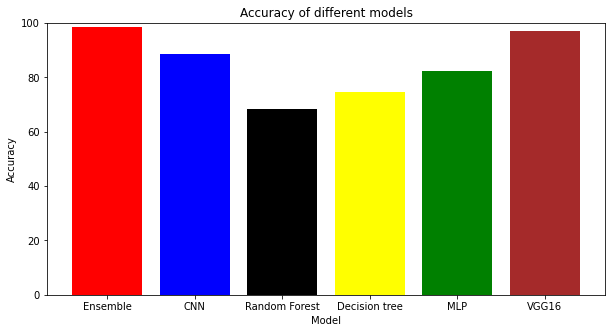

In [ ]:
xaxis=["Ensemble","CNN","Random Forest","Decision tree","MLP", "VGG16"]
yaxis=[ensem_acc*100,cnn_acc*100,rtree_acc*100,dtree_acc*100,mlp_acc*100,vgg_acc*100]
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color=['red','blue','black','yellow','green','brown'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of different models")
plt.ylim([0,100])
plt.show()

In [ ]:
# Saving the ensemble model with the highest accuracy
from tensorflow.keras.models import save_model
model.save("brain_tumor_detector.h5")